In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook as tqdm
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
# import nct
import bct
import pandas as pd

import pickle 
import _pickle as cPickle
import gzip

def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [3]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [4]:
dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/VSweep/'
saveFig='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'

In [5]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_10sets_NWN.pkl'
NWN=decompress_pickle(name)
name2='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_separated_10sets_NWN.pkl'
NWN_separate=decompress_pickle(name2)

In [11]:
# len(NWN_separate)

In [12]:
# nwnSep1=NWN_separate[1][5][0]['G']
# nwnSep2=NWN_separate[1][5][1]['G']

In [14]:
# numNWs=6
# nws=np.linspace(0,8,6)
# graph=[]
# adjMat=[]

# #Loop through rewiring from completely modular to completely integrated
# for i in tqdm(range(numNWs)):
#     if i == 0:
#         graph.append(nwnGraph.copy())
#     else:
#         currGraph=graph[i-1].copy()
#         temp=[]
#         temp=nx.double_edge_swap(nwnGraph.copy(),nswap=int(np.exp(nws[i])),max_tries=100000,seed=10)
#         temp.remove_edges_from(list(nx.selfloop_edges(temp)))
#     if i > 0:
#         graphz.append(max(connected_component_subgraphs(temp), key=len))
#     adjMat.append(nx.adjacency_matrix(graph[i]))

In [6]:
graph=[[] for i in range(len(NWN))]
adjMat=[[] for i in range(len(NWN))]

for nw in range(len(NWN)):
    nwnGraph=NWN[nw][5]['G']
    numNWs=6
    nws=np.linspace(0,8,6)

    #Loop through rewiring from completely modular to completely integrated
    for i in tqdm(range(numNWs)):
        if i == 0:
            graph[nw].append((nwnGraph.copy()))
            currGraph=graph[nw][i]
        else:
            currGraph=graph[nw][i-1].copy()
        temp=[]
        temp=nx.double_edge_swap(currGraph,nswap=int(np.exp(nws[i])),max_tries=10000,seed=10)
        temp.remove_edges_from(list(nx.selfloop_edges(temp)))
        if i > 0:
            graph[nw].append(max(connected_component_subgraphs(temp), key=len))
        adjMat[nw].append(nx.adjacency_matrix(graph[nw][i]))

In [8]:
avgDeg=[]
for i in range(len(graph)):
    for j in range(len(graph[i])):
        avgDeg.append(np.mean([val for deg,val in graph[i][j].degree()]))

In [286]:
#save networks separately so Dask can run it more efficiently
count = 1
for i in tqdm(range(len(graph))):#For each network
    for j in range(len(graph[i])): #for each density
        n=connectivity__(graph=graph[i][j])
        compressed_pickle(n,dataLoc+'/NWN_Network_2modules_Rewired_'+str(i+1)+'_'+str(j+1)+'.pkl')
        count = count+1

In [6]:
compressed_pickle(graph,dataLoc+'2ModuleSameAvgDegGraphs')

NameError: name 'graph' is not defined

In [7]:
graph=decompress_pickle(dataLoc+'2ModuleSameAvgDegGraphs')

In [8]:
#2 Electrodes
electrodes=[[73,115,173,264],[88,38,229,282],[64,123,193,240],[149,24,247,217],[128,138,190,216],[134,137,236,230],[71,104,191,242],[122,97,187,202],[57,2,166,169],[2,11,215,236]]
electrodes_separate=[[73,115,173-150,264-150],[88,38,229-150,282-150],[64,123,193-150,240-150],[149,24,247-150,217-150],[128,138,190-150,216-150],[134,137,236-150,230-150],[71,104,191-150,242-150],[122,97,187-150,202-150],[57,2,166-150,169-150],[2,11,215-150,236-150]]

#4 Electrodes
# electrodes=[25,22,295,288]#[117, 98, 171, 168]## Electrodes in each module

In [19]:
#2 Electrodes Placed Differently
electrodes_different=[[73,173,115,264],[88,229,38,282],[64,193,123,240],[149,247,24,217],[128,190,138,216],[134,236,137,230],[71,191,104,242],[122,187,97,202],[57,166,2,169],[2,215,11,236]]

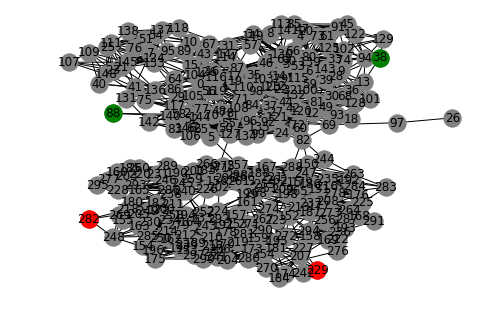

In [20]:
#Unseparated Networks
nw=1
mod=0
pos=nx.kamada_kawai_layout(graph[nw][mod])
nx.draw(graph[nw][mod],pos=pos,with_labels=True,node_color='grey')
nx.draw_networkx_nodes(graph[nw][mod],pos=pos,nodelist=[electrodes_different[nw][0],electrodes_different[nw][2]],node_color='green')
nx.draw_networkx_nodes(graph[nw][mod],pos=pos,nodelist=[electrodes_different[nw][1],electrodes_different[nw][3]],node_color='red')

In [12]:
# ci=[None]*len(graph)
# q=[None]*len(graph)
# for x in range(len(graph)):
#     ci[x],q[x]=bct.community_louvain(np.array(nx.adjacency_matrix(graph[x]).todense()),gamma=1.1)

In [19]:
#Find nodes in each module:
np.random.seed(10)
module1=[]
module2=[]
for nw in range(len(graph)):
    for mod in range(len(graph[nw])):
        ci,q=bct.community_louvain(np.array(nx.adjacency_matrix(graph[nw][0]).todense()),gamma=0.1)
        module1.append(np.array([i for i in graph[nw][0].nodes])[ci==1])
        module2.append(np.array([i for i in graph[nw][0].nodes])[ci==2])
module1=np.array(module1).reshape(10,6)
module2=np.array(module2).reshape(10,6)


In [320]:
module1[0][0][0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149])

In [9]:
# savemat(dataLoc+'Module Data Modular NWNs.mat',{'Mod1':module1,'Mod2':module2})
temp=loadmat(dataLoc+'Module Data Modular NWNs.mat')
module1=temp['Mod1']
module2=temp['Mod2']

In [14]:
# #Separated Networks

# fig,axes=plt.subplots(1,2,figsize=(10,4))
# ax=axes[0]
# pos=nx.kamada_kawai_layout(nwnSep1)
# nx.draw(nwnSep1,pos=pos,with_labels=False,node_color='grey',node_size=20,ax=ax)
# nx.draw_networkx_nodes(nwnSep1,pos=pos,nodelist=[electrodes_separate[0]],node_color='green',ax=ax)
# nx.draw_networkx_nodes(nwnSep1,pos=pos,nodelist=[electrodes_separate[1]],node_color='red',ax=ax)
# ax=axes[1]
# pos=nx.kamada_kawai_layout(nwnSep2)
# nx.draw(nwnSep2,pos=pos,with_labels=False,node_color='grey',node_size=20,ax=ax)
# nx.draw_networkx_nodes(nwnSep2,pos=pos,nodelist=[electrodes_separate[2]],node_color='green',ax=ax)
# nx.draw_networkx_nodes(nwnSep2,pos=pos,nodelist=[electrodes_separate[3]],node_color='red',ax=ax)

# plt.savefig(saveFig+'2 Module NWNs Separate SameAvgDeg_#2.pdf',format='pdf',dpi=300)

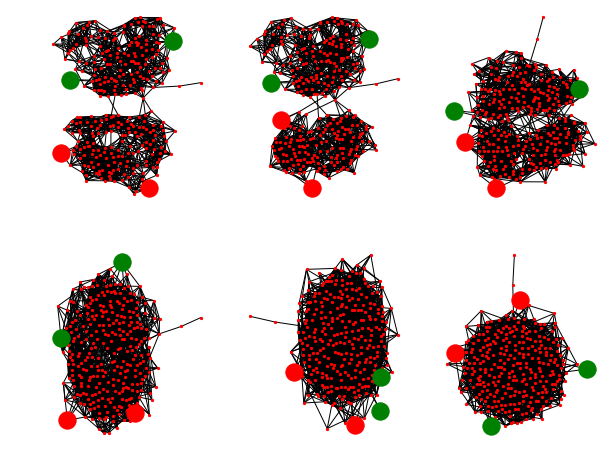

In [1740]:
fig,axes=plt.subplots(2,3,figsize=(10,8))
network=1
i = 0
for ax in axes.flat:
    pos=nx.kamada_kawai_layout(graph[1][i])
    nx.draw(graph[1][i],pos=pos,ax=ax,node_size=5)#,node_color=colors[i])
    nx.draw_networkx_nodes(graph[1][i],pos=pos,nodelist=[electrodes[1][0],electrodes[1][2]],node_color='green',ax=ax)
    nx.draw_networkx_nodes(graph[1][i],pos=pos,nodelist=[electrodes[1][1],electrodes[1][3]],node_color='red',ax=ax)
    i=i+1
    
plt.savefig(saveFig+'2 Module NWNs SameAvgDeg_ElecsInDifMods.pdf',format='pdf',dpi=300)

In [408]:
mod=[[] for i in range(len(NWN))]
avgDeg=[[] for i in range(len(NWN))]
A=[]
count=0
for i in tqdm(range(len(graph))):
    for j in range(len(graph[i])):
        G=graph[i][j]
        A.append(np.array(nx.adjacency_matrix(G).todense()))
        avgDeg[i].append(np.mean(np.array(G.degree())[:,1]))
        ci,q=bct.community_louvain(A[count],gamma=1.1)
        mod[i].append(q)
        count=count+1
# AdjMat={'AdjMat':A}
# savemat(dataLoc+'modularNWs_MultiTasking_AdjMat.mat',AdjMat)

In [332]:
temp=loadmat(dataLoc+'modularNWs_MultiTasking_AdjMat_smallworld.mat')
smallworld=temp['smallworld']

In [11]:
onAmp=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]#np.linspace(0,10,201)
voltNames=['0p2','0p5','0p75','1','1p25','1p5','1p75','2','3','5','10']

In [22]:
from random import gauss
from pandas import Series

In [20]:
def MC_k_new(network, k = 1, node_list=[], transient = 100):
#     node_list=n_outs#len(node_list)
    signal = network.stimulus[0].signal[transient:]
    wire_voltage = network.wireVoltage[transient:]
    T, N = wire_voltage.shape
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]
    try:
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        mc = (np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result))
        return mc
    except:
        return 0

In [21]:
def nonLinearTrans_specificNodes(network, targetType, nodesList, repeats = 1):
    """
    targetType can be DoubleFrequency and all other possible biasType.
    wireVoltage[T,N] can also be the first positional parameter.
    """
    from edamame.core.simSettings import stimulus__

    if targetType == 'DoubleFrequency':
        target = stimulus__(network.stimulus[0].biasType, network.TimeVector, f = 2*network.stimulus[0].f).signal
    else:
        target = stimulus__(targetType, network.TimeVector, f = network.stimulus[0].f).signal
        
    wireVoltage = network.wireVoltage    
    T, N = wireVoltage.shape
    output = dict()
    accuracy = np.zeros(repeats)
    weight = np.zeros((repeats, len(nodesList)+1))
    result = np.zeros((repeats, T))
    for i in range(repeats):
        lhs = np.hstack((np.ones((T, 1)), wireVoltage[:,nodesList]))
        weight[i,:] = np.linalg.lstsq(lhs, target, rcond = None)[0]
#         set_trace()
        result[i,:] = np.dot(lhs, weight[i,:])
        accuracy[i] = 1-getRNMSE(result[i,:], target)
        
    output['weight'] = np.mean(weight, axis = 0)
    output['result'] = np.mean(result, axis = 0)
    output['accuracy'] = np.mean(accuracy)
    output['target'] = target
    
    return output 

### Single Tasking:

In [430]:
def voltSweep(j,k,amp=2):
    ampName=str(amp).replace('.','p')
    Connectivity=decompress_pickle(dataLoc+'NWN_Network_2modules_Rewired_'+str(j+1)+'_'+str(k+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    
    stimulus=[]
    dt = 1e-3
    f=0.5
    Time=5

    #Choose Electrode Pattern

    stimulus.append((stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training
    
    results_minMax=runSim(connectivity__(graph=Graph),stimulus=stimulus, contactMode='farthest',T = Time, dt = dt, onAmp = amp, biasType='AC',f=f,junctionMode='tunneling',findFirst=False)
    
    results={'JunctionConductance':results_minMax.junctionConductance[-1],'JunctionVoltage':results_minMax.junctionVoltage[-1],'Switch':results_minMax.junctionSwitch[-1],'Source':results_minMax.sources[0:2],'Drain':results_minMax.drains[0:2],'Signal':results_minMax.stimulus,'conductance':results_minMax.conductance}
    compressed_pickle(results,dataLoc+'_NLT_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')
#             compressed_pickle(results,r'/project/NASN/Alon/'+nwType+'/'+nwType+' Results/'+nwType+'_NLT_Simulation_'+'Density_Network_'+str(j+1)+'_'+ampName+'v.pkl')
    results_minMax.frequency=f
    results_minMax.dt=dt
    period=1/f
    
    nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     if elecs[0] in module1:   #if the NLT electrode is in module one, we only want to sample from those nodes
#         nodesList=module1 #only want nodes in first module
#     else:
#         nodesList=module2
        
    ResultSqu = nonLinearTrans_specificNodes(results_minMax,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu=ResultSqu['accuracy']
        
    return nwSqu


In [2]:
def get_MC_Voltsweep(j,k,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    
    Connectivity=decompress_pickle(dataLoc+'NWN_Network_2modules_Rewired_'+str(j+1)+'_'+str(k+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    
    stimulus=[]
    stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=signal_expand(np.random.random(1000)*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                stimulus=stimulus,
                biasType = 'Custom', customSignal = signal_expand(np.random.random(1000)*2*amp-amp, dur), 
                junctionMode = 'tunneling', 
                electrodes=elecs[-2:],
                contactMode = 'preSet',
                findFirst=False, disable_tqdm=True)    
    
    nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
    results={'JunctionConductance':simRAND.junctionConductance[-1],'JunctionVoltage':simRAND.junctionVoltage[-1],'Switch':simRAND.junctionSwitch[-1],'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus,'conductance':simRAND.conductance}
    compressed_pickle(results,dataLoc+'_MC_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    mcRAND = [MC_k_new(simRAND, m, node_list=nodesList) for m in range(dur, len(nodesList)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND), simRAND, Graph, dur
    else:
        return np.sum(mcRAND)

In [3]:
initMC=[]
for i in tqdm(range(len(onAmp))): #for each voltage
    for j in range(len(NWN)): #for each network
        for k in range(6):#for each modularity:        
            initMC.append(inputPacker(get_MC_Voltsweep,j,k,amp=onAmp[i]))

NameError: name 'tqdm' is not defined

In [435]:
init=[]
for i in tqdm(range(len(onAmp))): #for each voltage
    for j in range(len(NWN)): #for each network
        for k in range(numNWs):#for each modularity:
            init.append(inputPacker(voltSweep,j,k,amp=onAmp[i]))

In [436]:
resultNLT=para_run(voltSweep,init,nCPU=10,start_method='fork')

In [439]:
resultNLT=np.array(resultNLT).reshape(11,10,6)

In [71]:
resultMC=[]
elecs=electrodes
for i in tqdm(range(10)):
    resultMC.append(para_run(get_MC_Voltsweep,initMC,nCPU=10,start_method='fork'))

In [100]:
avresultMC=np.mean(resultMC,axis=0)
stdresultMC=np.std(resultMC,axis=0)/np.sqrt(10)

In [101]:
avresultMC=np.array(avresultMC).reshape(11,10,6)

In [103]:
stdresultMC=np.array(stdresultMC).reshape(11,10,6)

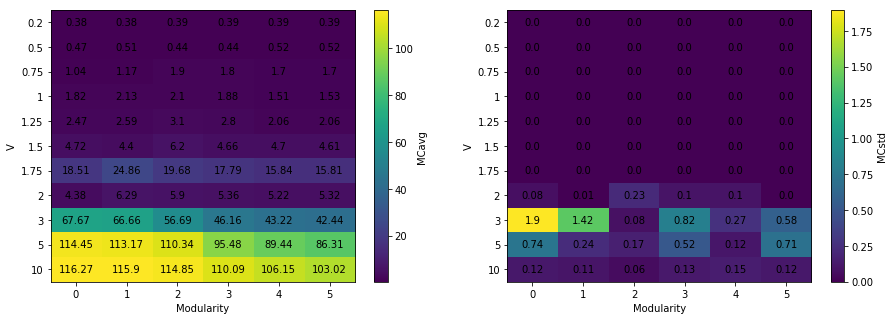

In [104]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
# fig.subplots_adjust(wspace=0.3)
ax=axes[0]
a=ax.imshow(np.fliplr(np.mean(avresultMC,axis=1)),aspect='auto')
plt.colorbar(a,ax=ax,label='MCavg')
for (j,i),label in np.ndenumerate(np.fliplr(np.mean(avresultMC,axis=1))):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
ax.set_ylabel('V')

ax.set_xlabel('Modularity')


ax=axes[1]

b=ax.imshow(np.fliplr(np.mean(stdresultMC,axis=1)),aspect='auto')
plt.colorbar(b,ax=ax,label='MCstd')
for (j,i),label in np.ndenumerate(np.fliplr(np.mean(stdresultMC,axis=1))):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
ax.set_ylabel('V')
ax.set_xlabel('Modularity')


plt.savefig(saveFig+'Avg MC Single Task - VSweep 300NWN 2Modules SameAvgDeg_10NWS REWIRED.pdf',format='pdf',dpi=300)

In [453]:
resultNLT=resultNLT.reshape(11,60)

In [442]:
compressed_pickle([resultMC,resultNLT],dataLoc+'MC+NLT_RewiredModularityResults_SingleTask')

In [1121]:
[resultMC,resultNLT]=decompress_pickle(dataLoc+'MC+NLT_RewiredModularityResults_SingleTask')

In [1122]:
MC=[]
NLT=[]
for i in range(len(resultMC)):
    MC.append(np.array(resultMC[i]))
    NLT.append(np.hstack(np.array(resultNLT[i])))

In [1123]:
MC=np.array(np.double(MC)).reshape(11,60)
NLT=np.array(np.double(NLT)).reshape(11,60)

In [1124]:
tempResults=NLT.reshape(11,10,6)
tempResultsMC=MC.reshape((11,10,6))
newResults=[];newResultsMC=[]
for i in range(len(tempResults)):
    newResults.append(tempResults[i].T)
    newResultsMC.append(tempResultsMC[i].T)

In [1125]:
meanNLT=np.mean(newResults,axis=2)
meanMC=np.mean(newResultsMC,axis=2)
stdNLT=np.std(newResults,axis=2)
stdMC=np.std(newResultsMC,axis=2)
dfmeanMC_single=pd.DataFrame(meanMC)
dfmeanNLT_single=pd.DataFrame(meanNLT)
dfstdNLT_single=pd.DataFrame(stdNLT)
dfstdMC_single=pd.DataFrame(stdMC)

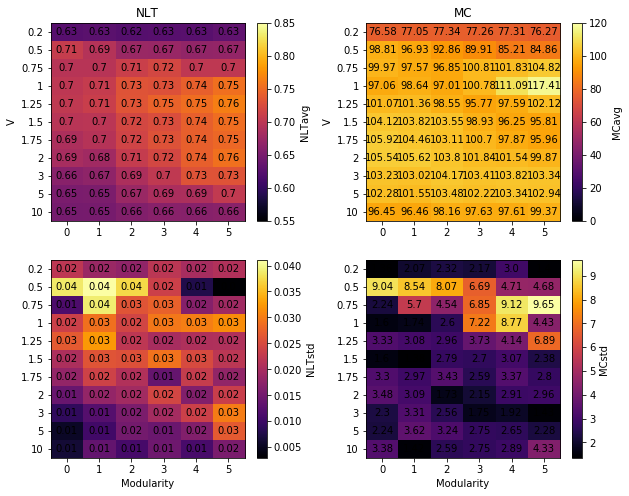

In [1126]:
plt.rcParams['pdf.fonttype'] = 42

fig,axes=plt.subplots(2,2,figsize=(10,8))
fig.subplots_adjust(wspace=0.3)
ax=axes[0][0]
ax.set_title('NLT')
a=ax.imshow(np.fliplr(dfmeanNLT),aspect='auto',cmap=plt.cm.inferno,vmin=0.55,vmax=0.85)
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(a,ax=ax,label='NLTavg')
for (j,i),label in np.ndenumerate(np.fliplr(dfmeanNLT)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')

ax=axes[0][1]
ax.set_title('MC')
b=ax.imshow(np.fliplr(dfmeanMC),aspect='auto',cmap=plt.cm.inferno,vmin=0,vmax=120)
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='MCavg')
for (j,i),label in np.ndenumerate(np.fliplr(dfmeanMC)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    
ax=axes[1][0]
b=ax.imshow(np.fliplr(dfstdNLT),aspect='auto',cmap=plt.cm.inferno)
ax.set_xlabel('Modularity')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='NLTstd')
for (j,i),label in np.ndenumerate(np.fliplr(dfstdNLT)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    
ax=axes[1][1]
b=ax.imshow(np.fliplr(dfstdMC),aspect='auto',cmap=plt.cm.inferno)
ax.set_xlabel('Modularity')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='MCstd')
for (j,i),label in np.ndenumerate(np.fliplr(dfstdMC)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')

# plt.savefig(saveFig+'Avg NLT and MC - VSweep 300NWN 2Modules SameAvgDeg_10NWS REWIRED.pdf',format='pdf',dpi=300)

### Multi Tasking

In [17]:
def get_MC_and_NLT(j,k,elecs,module1,module2,seed=[],noiseOn=False,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    f=0.5

    Connectivity=decompress_pickle(dataLoc+'NWN_Network_2modules_Rewired_'+str(j+1)+'_'+str(k+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    
    np.random.seed(seed)
    stimulus=[]
    #KEEP NLT CONSTANT WHILE CHANGING MC
    stimulus.append(stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,10,dt),f=f))
    stimulus.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
#     stimulus.append(stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,10,dt),f=f))
    stimulus.append(stimulus__(biasType='Custom',TimeVector=np.arange(0,10,dt),customSignal=signal_expand(np.random.random(int(1000/dur))*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
#     #White noise
#     if noiseOn:
#         noise=[gauss(0.0, 1.0) for i in range(1000)]
#         stimulus.append(stimulus__(biasType='Custom',TimeVector=np.arange(0,10,dt),customSignal=signal_expand(noise, dur)))
    
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                start_state =  init_state,
                stimulus=stimulus,
                onAmp=amp,
                junctionMode = 'tunneling', 
                contactMode = 'preSet',
                electrodes=elecs,
                findFirst=False, disable_tqdm=True)

    output={'JunctionConductance':simRAND.junctionConductance,'JunctionVoltage':simRAND.junctionVoltage,'WireVoltage':simRAND.wireVoltage,'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus}
#     if noiseOn:
#         compressed_pickle(output,dataLoc+'NLT+MC+NOISE_Electrodes_'+'REWIREDNetworkComparison_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')
#     else:
    compressed_pickle(output,dataLoc+'NLT+MC_Electrodes_seed10_wireVoltages'+'REWIRED_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

   
    nodesList=[]
    if elecs[2] in module1[k][0]:   #if the electrode is in module one, we only want to sample from those nodes
        nodesList=module1[k][0] #only want nodes in first module
    else: #otherwise, we want to sample from module two
        nodesList=module2[k][0] #only want nodes in second module
        
    # 2x NLT
    nlt2F = nonLinearTrans_specificNodes(simRAND,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu2=nlt2F['accuracy']
    
    # NORMAL MC
    #     mcRAND = [MC_k_new(simRAND, l, node_list=nodesList) for l in range(dur, len(nodesList)*dur, dur)]
    
    nodesList=[]
    if elecs[0] in module1[k][0]:  
        nodesList=module1[k][0] 
    else:
        nodesList=module2[k][0]    
        
    countK=0

    ResultSqu = nonLinearTrans_specificNodes(simRAND,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu=ResultSqu['accuracy']
    
    if return_sim:
        return np.sum(mcRAND), simRAND, nwSqu
    else:
        return nwSqu2,nwSqu#np.sum(mcRAND),nwSqu

In [411]:
def get_MC_and_NLT_separate(j,elecs=[],amp = 2,seed=[], dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    f=0.5
    
    temp=decompress_pickle(dataLoc+'NWN_Network_2modules_separated_10sets_'+str(j+1)+'.pkl')

    Connectivity1=temp[0]
    Connectivity2=temp[1]
    Graph1= nx.from_numpy_matrix(Connectivity1.adj_matrix)
    Graph2= nx.from_numpy_matrix(Connectivity2.adj_matrix)
    
    np.random.seed(seed)
    stimulus1=[]
    stimulus2=[]
    stimulus1.append(stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,10,dt),f=f))
    stimulus1.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
#     stimulus2.append(stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,10,dt),f=f))
    stimulus2.append(stimulus__(biasType='Custom',TimeVector=np.arange(0,10,dt),customSignal=signal_expand(np.random.random(1000)*2*amp-amp, dur)))
    stimulus2.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
    elecsNLT=elecs[:2]
    elecsMC=elecs[-2:]

    #NLT
#     simNLT= runSim(connectivity__(graph=Graph1), T = 10, dt = dt,
#                 onAmp=amp, f=f,
#                 stimulus=stimulus1, 
#                 junctionMode = 'tunneling', 
#                 contactMode = 'preSet',
#                 biasType='AC',   
#                 electrodes=elecsNLT,
#                 findFirst=False, disable_tqdm=True)
    
    simNLT2= runSim(connectivity__(graph=Graph2), T = 10, dt = dt,
                onAmp=amp, f=f,
                stimulus=stimulus2, 
                junctionMode = 'tunneling', 
                contactMode = 'preSet',
                biasType='AC',   
                electrodes=elecsMC,
                findFirst=False, disable_tqdm=True)
    #MC
#     simMC = runSim(connectivity__(graph=Graph2), T = 10, dt = dt,
#                 stimulus=stimulus2,
#                 biasType = 'Custom', customSignal = signal_expand(np.random.random(1000)*2*amp-amp, dur), 
#                 junctionMode = 'tunneling', 
#                 contactMode = 'preSet',
#                 electrodes=elecsMC,
#                 findFirst=False, disable_tqdm=True)    

#     activation = findCurrent(simRAND, 1)
    results={'JunctionConductance':simNLT2.junctionConductance,'JunctionVoltage':simNLT2.junctionVoltage,'Switch':simNLT2.junctionSwitch,'Source':simNLT2.sources[0:2],'Drain':simNLT2.drains[0:2],'Signal':simNLT2.stimulus,'conductance':simNLT2.conductance}
#     resultsMC={'JunctionConductance':simMC.junctionConductance,'JunctionVoltage':simMC.junctionVoltage,'Switch':simMC.junctionSwitch[-1],'Source':simMC.sources[0:2],'Drain':simMC.drains[0:2],'Signal':simMC.stimulus,'conductance':simMC.conductance}
#     compressed_pickle(results,dataLoc+'NLT_ElectrodesSeparated_seed10_'+'2modules_Rewired_Network_'+str(j+1)+'_'+ampName+'v.pkl')
    compressed_pickle(results,dataLoc+'NLTx2_ElectrodesSeparated_seed10_'+'2modules_Rewired_Network_'+str(j+1)+'_'+ampName+'v.pkl')
  
    # NLT 2 frequency
    nodesList=[i for i in Graph2.nodes]
    ResultSqu2 = nonLinearTrans_specificNodes(simNLT2,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu2=ResultSqu2['accuracy']

    #MC
#     mcRAND = [MC_k_new(simMC, l, node_list=nodesList) for l in range(dur, len(nodesList)*dur, dur)]
    
#     nodesList2=[i for i in Graph1.nodes] #only want nodes in first module

#     countK=0
#     #Need to write a way to read out only from the nodes in nodesList
#     ResultSqu = nonLinearTrans_specificNodes(simNLT,'Square',nodesList2, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
#     nwSqu=ResultSqu['accuracy']
    
    if return_sim:
        return np.sum(mcRAND), simRAND, nwSqu
    else:
        return nwSqu2#np.sum(mcRAND),nwSqu

In [412]:
initMCNLT_sep=[[] for i in range(10)]
j=0
seed=[]
for nTimes in range(10):
    seed.append(np.arange(10,21))
    for i in tqdm(range(len(onAmp))): #for each voltage
        for j in range(len(electrodes_separate)):
            initMCNLT_sep[nTimes].append(inputPacker(get_MC_and_NLT_separate,j,elecs=electrodes_separate[j],amp=onAmp[i],seed=seed[nTimes]))

#### SEPARATED MODULES 

In [436]:
get_MC_and_NLT_separate(0,elecs=electrodes_separate[0],amp=onAmp[4],seed=20)

> <ipython-input-435-9d04f4106a23>(23)nonLinearTrans_specificNodes()
     21         weight[i,:] = np.linalg.lstsq(lhs, target, rcond = None)[0]
     22         set_trace()
---> 23         result[i,:] = np.dot(lhs, weight[i,:])
     24         accuracy[i] = 1-getRNMSE(result[i,:], target)
     25 

ipdb> lhs.shape
(1000, 151)
ipdb> target.shape
(1000,)
ipdb> weight
array([[ 3.02616202e-02,  4.92178711e+08,  1.65442610e+09, ...,
        -1.44968523e+08, -9.21235734e+08, -2.01653103e+07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],


BdbQuit: 

In [413]:
#Run
resultMCNLT_sep=[None]*10
for i in tqdm(range(10)):
    resultMCNLT_sep[i]=para_run(get_MC_and_NLT_separate,initMCNLT_sep[i],nCPU=10,start_method='fork')

#### COMBINED 

In [23]:
noiseOn=False #Add white noise?

if noiseOn:
    elecs=electrodesNoise
else:
    elecs=electrodes
initMCNLT=[[] for i in range(10)]
seed=np.arange(10,21) #10 different seeds
for nTimes in tqdm(range(10)):
    for i in range(len(onAmp)): #for each voltage
        for j in range(len(graph)): #for each network
            for k in range(len(graph[0])): #for each modularity
                initMCNLT[nTimes].append(inputPacker(get_MC_and_NLT,j,k,electrodes[j],module1[j],module2[j],noiseOn=noiseOn,amp=onAmp[i],seed=seed[nTimes]))

In [24]:
#test
get_MC_and_NLT(0,5,electrodes[0],module1[0],module2[0],seed=seed[0],noiseOn=noiseOn,amp=onAmp[0])

(0.32243473292560637, 0.5929989285086376)

In [25]:
#Run
resultMCNLT=[None]*10
for i in tqdm(range(10)):
    resultMCNLT[i]=para_run(get_MC_and_NLT,initMCNLT[i],nCPU=10,start_method='fork')

In [ ]:
# resultMCNLT_sep=np.array(resultMCNLT_sep).reshape(10,660)

In [ ]:
MC_sep=[]
NLT_sep=[]
for i in range(len(resultMCNLT_sep)):
    MC_sep.append(np.array(resultMCNLT_sep[i]).T[0])
    NLT_sep.append(np.array(resultMCNLT_sep[i]).T[1])

In [420]:
NLT_sep=resultMCNLT_sep

In [421]:
# MCsep=np.mean(MC_sep,axis=0)
NLTsep=np.mean(NLT_sep,axis=0)

In [422]:
# MC=[]
NLT2=[]
NLT=[]
for i in range(len(resultMCNLT)):
#     MC.append(np.array(resultMCNLT[i]).T[0].reshape(11,10,6))
    NLT2.append(np.array(resultMCNLT[i]).T[0].reshape(11,10,6))
    NLT.append(np.array(resultMCNLT[i]).T[1].reshape(11,10,6))

In [423]:
# MC=np.mean(MC,axis=0)
NLT=np.mean(NLT,axis=0)
NLT2=np.mean(NLT2,axis=0)

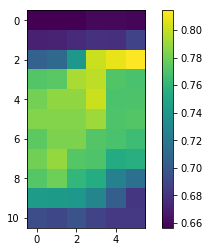

In [424]:
plt.imshow(np.mean(NLT,axis=1))

plt.colorbar()

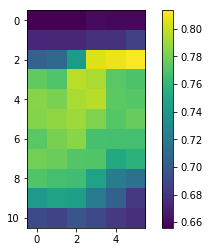

In [425]:
plt.imshow(np.mean(NLT2,axis=1))
plt.colorbar()

In [428]:
MC.shape

2

In [426]:
# MC_sep=np.array(np.double(MCsep)).reshape(11,10)
NLT_sep=np.array(np.double(NLTsep)).reshape(11,10)

In [427]:
compressed_pickle([NLT2,NLT],dataLoc+'NLTx2+NLT_RewiredModularityResults_seed10')
compressed_pickle([NLT_sep],dataLoc+'NLTx2_RewiredModularityResults_seed10_separated')

In [71]:
MC=[]
NLT=[]
MC_same=[]
NLT_same=[]
MC_sep=[]
NLT_sep=[]

In [404]:
[NLT2,NLT]=decompress_pickle(dataLoc+'NLTx2+NLT_RewiredModularityResults_seed10')
# [MC_same,NLT_same]=decompress_pickle(dataLoc+'MC+NLT_RewiredModularityResults_seed10')
[MC_sep,NLT_sep]=decompress_pickle(dataLoc+'MC+NLT_RewiredModularityResults_seed10_separated')
[NLT2_sep]=decompress_pickle(dataLoc+'NLTx2_RewiredModularityResults_seed10_separated')

In [405]:
# NLT_same=NLT_same.reshape(11,60)
# MC_same=MC_same.reshape(11,60)

In [137]:
#COMBINE NLT AND NLT SEP + NORMALIZE RESULTS
NLT_combined=np.concatenate((np.fliplr(NLT_same).reshape(11,10,6),np.array(NLT_sep).reshape(11,10)[...,None]),axis=2)
MC_combined=np.concatenate((np.fliplr(MC_same).reshape(11,10,6),np.array(MC_sep).reshape(11,10)[...,None]),axis=2)


tempResults=NLT.reshape(11,10,6)
tempResultsMC=MC.reshape((11,10,6))
newResults=[];newResultsMC=[]
for i in range(len(tempResults)):
    newResults.append(tempResults[i].T)
    newResultsMC.append(tempResultsMC[i].T)


tempResults_same=NLT_combined.reshape(11,10,7)
tempResultsMC_same=MC_combined.reshape((11,10,7))
newResults_same=[];newResultsMC_same=[]
for i in range(len(tempResults_same)):
    newResults_same.append(tempResults_same[i].T)
    newResultsMC_same.append(tempResultsMC_same[i].T)
    
newResults_same=np.array(newResults_same).reshape(11,70)
newResultsMC_same=np.array(newResultsMC_same).reshape(11,70)

newResults=np.array(newResults).reshape(11,60)
newResultsMC=np.array(newResultsMC).reshape(11,60)

maxMCval_same=np.max(np.max(newResultsMC_same))
maxNLTval_same=np.max(np.max(newResults_same))
minMCval_same=np.min(np.min(newResultsMC_same))
minNLTval_same=np.min(np.min(newResults_same))

maxMCval=np.max([np.max(newResultsMC),np.max(maxMCval_same)])
maxNLTval=np.max([np.min(newResults),np.max(maxNLTval_same)])
minMCval=np.min([np.max(newResultsMC),np.min(minMCval_same)])
minNLTval=np.min([np.min(newResults),np.min(minNLTval_same)])

dfMC_diffMax_same=[]
dfNLT_diffMax_same=[]
for j in range(len(onAmp)):
    for i in range(70):
        dfMC_diffMax_same.append(1-((maxMCval_same-np.fliplr(newResultsMC_same)[j][i])/(maxMCval_same-minMCval_same)))
    for i in range(70):
        dfNLT_diffMax_same.append(1-((maxNLTval_same-np.fliplr(newResults_same)[j][i])/(maxNLTval_same-minNLTval_same)))
        
dfMC_diffMax=[]
dfNLT_diffMax=[]
for j in range(len(onAmp)):
    for i in range(60):
        dfMC_diffMax.append(1-((maxMCval-np.fliplr(newResultsMC)[j][i])/(maxMCval-minMCval)))
    for i in range(60):
        dfNLT_diffMax.append(1-((maxNLTval-np.fliplr(newResults)[j][i])/(maxNLTval-minNLTval)))
        

tempResults_same=np.array(dfNLT_diffMax_same).reshape(11,7,10)
tempResultsMC_same=np.array(dfMC_diffMax_same).reshape((11,7,10))
newResults_same=[];newResultsMC_same=[]
for i in range(len(tempResults_same)):
    newResults_same.append(tempResults_same[i].T)
    newResultsMC_same.append(tempResultsMC_same[i].T)
    
    
tempResults=np.array(dfNLT_diffMax).reshape(11,6,10)
tempResultsMC=np.array(dfMC_diffMax).reshape((11,6,10))
newResults=[];newResultsMC=[]
for i in range(len(tempResults)):
    newResults.append(tempResults[i].T)
    newResultsMC.append(tempResultsMC[i].T)
    
meanNLT_same=np.mean(newResults_same,axis=1)
meanMC_same=np.mean(newResultsMC_same,axis=1)
meanNLT=np.mean(newResults,axis=1)
meanMC=np.mean(newResultsMC,axis=1)
seNLT=np.std(newResults,axis=1)/np.sqrt(10)
seMC=np.std(newResultsMC,axis=1)/np.sqrt(10)

seNLT_same=np.std(newResults_same,axis=1)/np.sqrt(10)
seMC_same=np.std(newResultsMC_same,axis=1)/np.sqrt(10)
meanNLT=np.mean(newResults,axis=1)
meanMC=np.mean(newResultsMC,axis=1)
seNLT=np.std(newResults,axis=1)/np.sqrt(10)
seMC=np.std(newResultsMC,axis=1)/np.sqrt(10)

TypeError: only integer scalar arrays can be converted to a scalar index

In [144]:
# #COMBINE NLT AND NLT SEP + DON'T NORMALIZ RESULTS

# meanNLT=[];dfmeanNLT=[];dfmeanNLT=[];meanMC=[];dfmeanMC=[];dfstdMC=[]
# meanNLT_same=[];dfmeanNLT_same=[];dfmeanNLT_same=[];meanMC_same=[];dfmeanMC_same=[];dfstdMC_same=[]

# tempResults=NLT.reshape(11,10,6);tempResultsMC=MC.reshape((11,10,6))
# tempResults2=NLT_same.reshape(11,10,6);tempResultsMC2=MC_same.reshape((11,10,6))

# newResults=[];newResultsMC=[]
# newResults_same=[];newResultsMC_same=[]

# for i in range(len(tempResults)):
#     newResults.append(tempResults[i].T)
#     newResults_same.append(tempResults2[i].T)
#     newResultsMC.append(tempResultsMC[i].T)
#     newResultsMC_same.append(tempResultsMC2[i].T)
    
# maxMCval=np.max([np.max(newResultsMC),np.max(newResultsMC_same),np.max(MCsep)])
# maxNLTval=np.max([np.max(newResults),np.max(newResults_same),np.max(NLTsep)])
# minMCval=np.min([np.min(newResultsMC),np.min(newResultsMC_same),np.min(MCsep)])
# minNLTval=np.min([np.min(newResults),np.min(newResults_same),np.min(NLTsep)])

# dfMC_diffMax=[];dfMC_diffMax_same=[]
# dfNLT_diffMax=[];dfNLT_diffMax_same=[]

# newResults=np.array(newResults).reshape(11,60)
# newResultsMC=np.array(newResultsMC).reshape(11,60)
# newResults_same=np.array(newResults_same).reshape(11,60)
# newResultsMC_same=np.array(newResultsMC_same).reshape(11,60)

# for j in range(len(onAmp)):
#     for i in range(60):
#         dfMC_diffMax.append(1-((maxMCval-np.fliplr(newResultsMC)[j][i])/(maxMCval-minMCval)))
#         dfMC_diffMax_same.append(1-((maxMCval-np.fliplr(newResultsMC_same)[j][i])/(maxMCval-minMCval)))
#     for i in range(60):
#         dfNLT_diffMax.append(1-((maxNLTval-np.fliplr(newResults)[j][i])/(maxNLTval-minNLTval)))
#         dfNLT_diffMax_same.append(1-((maxNLTval-np.fliplr(newResults_same)[j][i])/(maxNLTval-minNLTval)))

# tempResults=[];tempResults2=[]
# tempResultsMC=[];tempResultsMC2=[]

# tempResults=np.array(dfNLT_diffMax).reshape(11,6,10)
# tempResultsMC=np.array(dfMC_diffMax).reshape((11,6,10))
# tempResults2=np.array(dfNLT_diffMax_same).reshape(11,6,10)
# tempResultsMC2=np.array(dfMC_diffMax_same).reshape((11,6,10))
# newResults=[];newResultsMC=[]
# newResults_same=[];newResultsMC_same=[]

# for i in range(len(tempResults)):
#     newResults.append(tempResults[i].T)
#     newResultsMC.append(tempResultsMC[i].T)
#     newResults_same.append(tempResults2[i].T)
#     newResultsMC_same.append(tempResultsMC2[i].T)    
    
# meanNLT=np.mean(newResults,axis=1)
# meanMC=np.mean(newResultsMC,axis=1)
# meanNLT_same=np.mean(newResults_same,axis=1)
# meanMC_same=np.mean(newResultsMC_same,axis=1)

# seNLT=np.std(newResults,axis=1)/np.sqrt(10)
# seMC=np.std(newResultsMC,axis=1)/np.sqrt(10)
# seNLT_same=np.std(newResults_same,axis=1)/np.sqrt(10)
# seMC_same=np.std(newResultsMC_same,axis=1)/np.sqrt(10)

In [146]:
dfmeanMC=np.fliplr(pd.DataFrame((meanMC)))
dfmeanNLT=np.fliplr(pd.DataFrame((meanNLT)))
# dfmeanMC_same=pd.DataFrame((meanMC_same))
# dfmeanNLT_same=pd.DataFrame((meanNLT_same))
# dfmeanMC_sep=pd.DataFrame(meanMC_sep)
# dfmeanNLT_sep=pd.DataFrame(meanNLT_sep)

dfseNLT=np.fliplr(pd.DataFrame((seNLT)))
dfseMC=np.fliplr(pd.DataFrame((seMC)))
# dfseNLT_same=pd.DataFrame((seNLT_same))
# dfseMC_same=pd.DataFrame((seMC_same))
# dfstdMC_sep=pd.DataFrame(stdMC_sep)
# dfstdNLT_sep=pd.DataFrame(stdNLT_sep)

In [63]:
dfmeanNLT_same=np.fliplr(dfmeanNLT_same)
dfmeanMC_same=np.fliplr(dfmeanMC_same)
dfseNLT_same=np.fliplr(dfseNLT_same)
dfseMC_same=np.fliplr(dfseMC_same)

In [74]:
import matplotlib.colors as clrs
cm1 = clrs.LinearSegmentedColormap.from_list("MyCmapName",["y","b","r","g"])

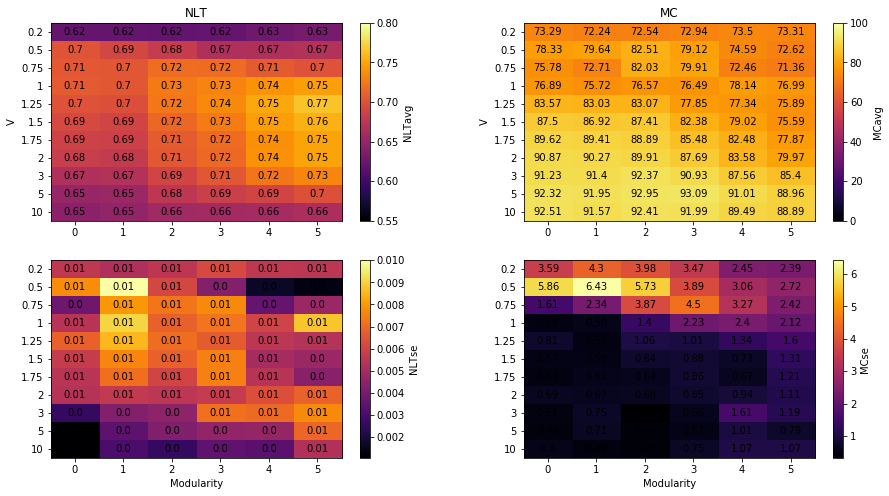

In [152]:
plt.rcParams['pdf.fonttype'] = 42

fig,axes=plt.subplots(2,2,figsize=(15,8))
fig.subplots_adjust(wspace=0.3)
ax=axes[0][0]
ax.set_title('NLT')
a=ax.imshow((dfmeanNLT),aspect='auto',vmin=0.55,vmax=0.8,cmap=plt.cm.inferno)
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(a,ax=ax,label='NLTavg')
for (j,i),label in np.ndenumerate((dfmeanNLT)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')

ax=axes[0][1]
ax.set_title('MC')
b=ax.imshow((dfmeanMC),aspect='auto',vmin=0,vmax=100,cmap=plt.cm.inferno)
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='MCavg')
for (j,i),label in np.ndenumerate((dfmeanMC)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    
ax=axes[1][0]
b=ax.imshow(dfseNLT,aspect='auto',cmap=plt.cm.inferno)
ax.set_xlabel('Modularity')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='NLTse')
for (j,i),label in np.ndenumerate((dfseNLT)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    
ax=axes[1][1]
b=ax.imshow((dfseMC),aspect='auto',cmap=plt.cm.inferno)
ax.set_xlabel('Modularity')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='MCse')
for (j,i),label in np.ndenumerate(dfseMC):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')

plt.savefig(saveFig+'Avg MultiTasking NLT+MC - VSweep 300NWN 2Modules SameAvgDeg 10sets REWIRED.pdf',format='pdf',dpi=300)

In [58]:
normalizedDifferenceNLT_MC=(dfmeanNLT+dfmeanMC)/2 #Mean of two normalized scores
normalizedDifferenceNLT_MC_SE=(dfseNLT+dfseMC)/2 #STD of two normalized scores

normalizedDifferenceNLT_MC_same=(dfmeanNLT_same+dfmeanMC_same)/2 #Mean of two normalized scores
normalizedDifferenceNLT_MC_same_SE=(dfseNLT_same+dfseMC_same)/2 #STD of two normalized scores

In [127]:
# normalizedDifferenceNLT_MC_same=np.fliplr(normalizedDifferenceNLT_MC_same)
# normalizedDifferenceNLT_MC_same_SE=np.fliplr(normalizedDifferenceNLT_MC_same_SE)

In [431]:
normalizedDifferenceNLT_MC

,0,1,2,3,4,5,6,7,8,9
0,21.104961,36.661909,39.212468,37.796241,38.224025,38.477908,39.179168,39.504857,39.320623,38.493467
1,23.792193,30.116494,43.803547,34.978099,38.440630,42.912488,45.579789,45.857562,44.223082,42.698788
2,29.097517,32.679505,41.281944,35.642521,37.534158,40.571390,42.185859,42.910478,39.380817,40.797201
3,36.109369,36.677918,40.344527,38.060781,36.558429,40.342588,40.068445,41.932150,38.389114,39.150678
4,38.856320,39.947089,41.039143,40.573253,38.454284,40.581059,40.093612,41.892959,40.639341,42.200157
5,41.116492,41.522486,42.285391,42.456913,40.139691,41.565336,41.933849,42.936851,42.315465,43.013231
6,42.084726,43.276995,43.513151,43.546846,41.595493,42.780856,43.408677,44.155757,43.186123,44.152514
7,41.788219,43.797469,44.451335,44.934960,42.174215,43.900566,43.891118,45.300010,44.174597,44.393830
8,42.557794,45.124039,45.323841,45.946597,44.012518,46.048457,46.078501,46.277881,45.545759,45.647451
9,43.934147,46.206702,45.974379,46.993759,45.944355,46.640124,46.471920,46.922337,46.490953,46.373253


In [371]:
# #Compare Electrodes in same module with electrodes in diff moduel

# fig,axes=plt.subplots(1,1,figsize=(5,4))


# ax=axes
# ax.set_ylim([0.35,0.85])
# y=(normalizedDifferenceNLT_MC)
# y_err=(normalizedDifferenceNLT_MC_SE)

# y_same=(normalizedDifferenceNLT_MC_same).T
# y_err_same=(normalizedDifferenceNLT_MC_same_SE).T
# x=range(len(onAmp))

# ax.plot(y[0],'--o',label='Integrated Diff',c='#840000')
# ax.fill_between(x,y[0]-y_err[0],y[0]+y_err[0],color='#840000',alpha=0.4)

# ax.plot(y_same[0],'-o',label='Integrated Same',c='r')
# ax.fill_between(x,y_same[0]-y_err_same[0],y_same[0]+y_err_same[0],color='r',alpha=0.4)

# ax.plot(y[5],'--o',label='Segregated Diff',c='#033500')
# ax.fill_between(x,y[5]-y_err[5],y[5]+y_err[5],color='#033500',alpha=0.4)

# ax.plot(y_same[5],'-o',label='Segregated Same',c='g')
# ax.fill_between(x,y_same[5]-y_err_same[5],y_same[5]+y_err_same[5],color='g',alpha=0.4)

# # ax.plot(y.T[-1],'--o',label='Separated',c='k')
# # ax.fill_between(x,y.T[-1]-y_err.T[-1],y.T[-1]+y_err.T[-1],color='k',alpha=0.4)

# ax.legend()

# ax.set_xticks(np.arange(0,len(onAmp)))
# ax.set_xticklabels(onAmp)
# ax.set_xlabel('V')
# ax.set_ylabel('Normalized MultiTasking Performance')

# plt.savefig(saveFig+'NORMALIZED MultiTasking Performance ElecsSame vs DiffMod 300NWN 10nws SameAvgDegree.pdf',format='pdf',dpi=300)


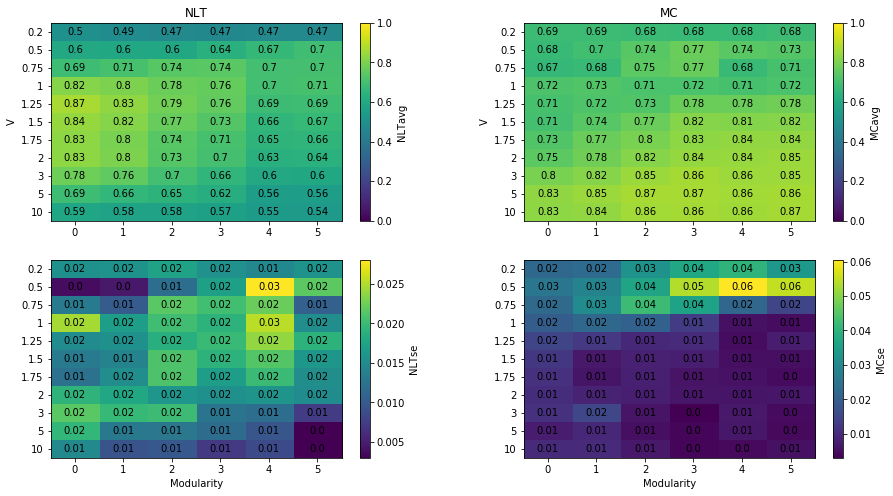

In [38]:
plt.rcParams['pdf.fonttype'] = 42

fig,axes=plt.subplots(2,2,figsize=(15,8))
fig.subplots_adjust(wspace=0.3)
ax=axes[0][0]
ax.set_title('NLT')
a=ax.imshow((dfmeanNLT_same),aspect='auto',vmin=0,vmax=1)
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(a,ax=ax,label='NLTavg')
for (j,i),label in np.ndenumerate(dfmeanNLT_same):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')

ax=axes[0][1]
ax.set_title('MC')
b=ax.imshow(((dfmeanMC_same)),aspect='auto',vmin=0,vmax=1)
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='MCavg')
for (j,i),label in np.ndenumerate(dfmeanMC_same):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    
ax=axes[1][0]
b=ax.imshow((dfseNLT_same),aspect='auto')
ax.set_xlabel('Modularity')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='NLTse')
for (j,i),label in np.ndenumerate((dfseNLT_same)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    
ax=axes[1][1]
b=ax.imshow((dfseMC_same),aspect='auto')
ax.set_xlabel('Modularity')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='MCse')
for (j,i),label in np.ndenumerate((dfseMC_same)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    
# plt.savefig(saveFig+'NORMALIZED MultiTasking Performance ElecsSame vs DiffMod 300NWN 10nws SameAvgDegree.pdf',format='pdf',dpi=300)
# plt.savefig(saveFig+'Avg NORMALIZED MultiTasking - VSweep 300NWN 2Modules ElecInDiffModules SameAvgDeg 10sets REWIRED.pdf',format='pdf',dpi=300)

In [246]:
# dfNLT_diffMax=np.array(dfNLT_diffMax).reshape(11,7)
# dfMC_diffMax=np.array(dfMC_diffMax).reshape(11,7)

In [247]:

# fig,axes=plt.subplots(1,2,figsize=(10,4))
# ax=axes[0]
# a1=ax.imshow(np.array(dfMC_diffMax),aspect='auto',cmap=plt.cm.viridis,vmin=0,vmax=1)
# # cb.ax.invert_yaxis() 
# ax.set_title('Normalized MC')
# ax.set_xlabel('Modularity')
# ax.set_ylabel('V')
# cb=plt.colorbar(a1,ax=ax)
# cb.set_ticks(np.around(np.arange(0,1,step=0.2),1))
# cb.set_ticklabels(np.around(np.arange(0,1.1,0.2),1))


# for (j,i),label in np.ndenumerate(np.array(dfMC_diffMax)):
#     ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')


# ax=axes[1]
# b1=ax.imshow(np.array(dfNLT_diffMax),aspect='auto',cmap=plt.cm.viridis,vmin=0,vmax=1)
# # cb.ax.invert_yaxis() 

# ax.set_title('Normalized NLT')
# ax.set_xlabel('Modularity')
# ax.set_ylabel('V')
# cb=plt.colorbar(b1,ax=ax)
# cb.set_ticks(np.around(np.arange(0,1,step=0.2),1))
# cb.set_ticklabels(np.around(np.arange(0,1.1,0.2),1))


# for (j,i),label in np.ndenumerate(np.array(dfNLT_diffMax)):
#     ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')

# plt.rcParams['pdf.fonttype'] = 42

# plt.savefig(saveFig+'Normalized MultiTasking - VSweep 300NWN 2Modules ElecInEachModule SameAvgDeg 10sets REWIRED.pdf',format='pdf',dpi=300)

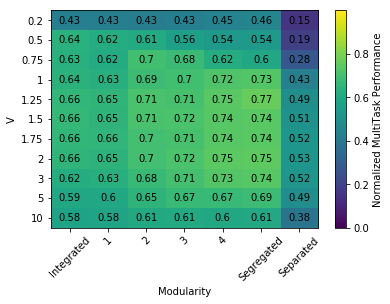

In [775]:
import matplotlib.colors
fig,ax=plt.subplots(1)
plt.imshow(np.abs(normalizedDifferenceNLT_MC_same),aspect='auto',cmap=plt.cm.viridis,vmin=0,vmax=1)
cb=plt.colorbar(label='Normalized MultiTask Performance',ax=ax)
# cb.ax.invert_yaxis() 
cb.set_ticks(np.arange(0,1,step=0.2))
cb.set_ticklabels(np.around(np.arange(0,1.1,0.2),2))


ax=plt.gca()
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(['Integrated','1','2','3','4','Segregated','Separated'],rotation=45)
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
ax.set_xlabel('Modularity')
ax.set_ylabel('V')
for (j,i),label in np.ndenumerate(np.abs(normalizedDifferenceNLT_MC_same)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
    

plt.rcParams['pdf.fonttype'] = 42
plt.savefig(saveFig+'Normalized Avg MultiTasking - VSweep 300NWN 2Modules ElecInEachModule SameAvgDeg 10 sets REWIRED.pdf',format='pdf',dpi=300)

##### NORMALIZE SINGLE TASK BASED ON MULTI-TASK RESULTS:

In [123]:
# dfMC_diffMax_SINGLE=[]
# dfNLT_diffMax_SINGLE=[]
# for j in range(len(onAmp)):
#     for i in range(6):
#         dfMC_diffMax_SINGLE.append(1-((maxMCval-np.fliplr(dfmeanMC_single)[j][i])/(maxMCval-minMCval)))
#     for i in range(6):
#         dfNLT_diffMax_SINGLE.append(1-((maxNLTval-np.fliplr(dfmeanNLT_single)[j][i])/(maxNLTval-minNLTval)))

In [124]:
# dfNLT_diffMax_SINGLE=np.array(dfNLT_diffMax_SINGLE).reshape(11,6)
# dfMC_diffMax_SINGLE=np.array(dfMC_diffMax_SINGLE).reshape(11,6)
# dfNLT_diffMax_stdSINGLE=np.array(dfNLT_diffMax_stdSINGLE).reshape(11,6)
# dfMC_diffMax_stdSINGLE=np.array(dfMC_diffMax_stdSINGLE).reshape(11,6)

In [125]:
# fig,axes=plt.subplots(1,2,figsize=(10,4))
# ax=axes[0]
# a1=ax.imshow(np.array(dfMC_diffMax_SINGLE),aspect='auto',cmap=plt.cm.viridis)
# cb=plt.colorbar(a1,ax=ax)
# # cb.ax.invert_yaxis() 
# ax.set_title('Normalized MC')
# ax.set_xlabel('Modularity')
# ax.set_ylabel('V')
# cb.set_ticks(np.around(np.arange(0,1,step=0.2),1))
# cb.set_ticklabels(np.around(np.arange(0,1.1,0.2),1))


# for (j,i),label in np.ndenumerate(np.array(dfMC_diffMax_SINGLE)):
#     ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')


# ax=axes[1]
# b1=ax.imshow(np.array(dfNLT_diffMax_SINGLE),aspect='auto',cmap=plt.cm.viridis)
# cb=plt.colorbar(b1,ax=ax)
# # cb.ax.invert_yaxis() 

# ax.set_title('Normalized NLT')
# ax.set_xlabel('Modularity')
# ax.set_ylabel('V')
# cb.set_ticks(np.around(np.arange(0,1,step=0.2),1))
# cb.set_ticklabels(np.around(np.arange(0,1.1,0.2),1))


# for (j,i),label in np.ndenumerate(np.array(dfNLT_diffMax_SINGLE)):
#     ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')

# plt.rcParams['pdf.fonttype'] = 42

# plt.savefig(saveFig+'Normalized Single Task - VSweep 300NWN 2Modules 1 Electrode SameAvgDeg 10sets REWIRED.pdf',format='pdf',dpi=300)

Text(0, 0.5, 'Normalized MultiTasking Performance')

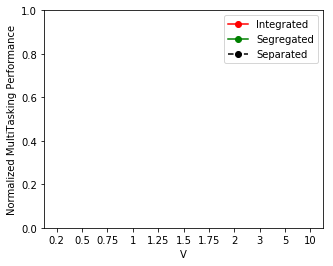

In [429]:
fig,axes=plt.subplots(1,1,figsize=(5,4))


# ax=axes[0]
# x=onAmp
# ax.plot(x,dfNLT_diffMax_SINGLE.T[0],'-o',label='Integrated',c='r')
# ax.plot(x,dfNLT_diffMax_SINGLE.T[-1],'-o',label='Segregated',c='g')

# ax.legend()
# ax.set_ylim([0,1.1])
# ax.set_ylabel('Single Task NLT')

# ax.set_xticks(np.arange(0,len(onAmp)))
# ax.set_xticklabels(onAmp)
# ax.set_xlabel('V')

# ax=axes[1]
# ax.set_ylim([0,1.1])

# ax.plot(x,dfMC_diffMax_SINGLE.T[0],'-o',label='Integrated',c='r')
# ax.plot(x,dfMC_diffMax_SINGLE.T[-1],'-o',label='Segregated',c='g')
# ax.legend()
# ax.set_ylabel('Single Task MC')

# ax.set_xticks(np.arange(0,len(onAmp)))
# ax.set_xticklabels(onAmp)
# ax.set_xlabel('V')

ax=axes
ax.set_ylim([0,1])
y=normalizedDifferenceNLT_MC_same.T
y_err=normalizedDifferenceNLT_MC_same_SE.T
x=range(len(onAmp))
ax.plot(y[0],'-o',label='Integrated',c='r')
ax.fill_between(x,y[0]-y_err[0],y[0]+y_err[0],color='r',alpha=0.4)

ax.plot(y[5],'-o',label='Segregated',c='g')
ax.fill_between(x,y[5]-y_err[5],y[5]+y_err[5],color='g',alpha=0.4)

ax.plot(y[6],'--o',label='Separated',c='k')
ax.fill_between(x,y[6]-y_err[6],y[6]+y_err[6],color='k',alpha=0.4)

ax.legend()

ax.set_xticks(np.arange(0,len(onAmp)))
ax.set_xticklabels(onAmp)
ax.set_xlabel('V')
ax.set_ylabel('Normalized MultiTasking Performance')

# plt.savefig(saveFig+'Normalized MultiTasking Performance 300NWN 10nws SameAvgDegree.pdf',format='pdf',dpi=300)

### Functional Subgraphs:

#### Separated

In [184]:
MC_sep=[[[] for j in range(len(NWN))] for i in range(len(onAmp))]
for volt in tqdm(range(len(onAmp))):
    for i in range(len(NWN)):
        name2=dataLoc+'MC_ElectrodesSeparated_seed10_'+'2modules_Rewired_Network_'+str(i+1)+'_'+voltNames[volt]+'v.pkl'
        MC_sep[volt][i].append(decompress_pickle(name2))

In [191]:
NLT_sep=[[[] for j in range(len(NWN))] for i in range(len(onAmp))]
for volt in tqdm(range(len(onAmp))):
    for i in range(len(NWN)):
        name2=dataLoc+'NLT_ElectrodesSeparated_seed10_'+'2modules_Rewired_Network_'+str(i+1)+'_'+voltNames[volt]+'v.pkl'
        NLT_sep[volt][i].append(decompress_pickle(name2))

In [432]:
len(NWN)

10

In [ ]:
MCJuncVolt=[]
for i in range(len(NLT_sep)):
    for j in range(len(NLT_sep[i])):
        MCJuncVolt.append(MC_sep[i][j][0]['JunctionVoltage'])   

In [192]:
NLTJuncVolt=[]
for i in range(len(NLT_sep)):
    for j in range(len(NLT_sep[i])):
        NLTJuncVolt.append(NLT_sep[i][j][0]['JunctionVoltage'])   

In [263]:
# #Draw conductance plots of each separated module:
# NLTcond=[]
# for i in range(len(NLT_sims)):
#     for j in range(len(NLT_sims[i])):
#         NLTcond.append(NLT_sims[i][j]['conductance'])
NLTcond=[]
NLTJuncCond=[[None]*len(NLT_sep[0]) for i in range(len(NLT_sep))]
NLTsignal=[]
for i in range(len(NLT_sep)):
    for j in range(len(NLT_sep[i])):
        NLTJuncCond[i][j]=(NLT_sep[i][j][0]['JunctionConductance'])   
        NLTcond.append(NLT_sep[i][j][0]['conductance'])   
        NLTsignal.append(NLT_sep[i][j][0]['Signal'][0].signal)       

In [254]:
# #Draw conductance plots of each separated module:
# NLTcond=[]
# for i in range(len(NLT_sims)):
#     for j in range(len(NLT_sims[i])):
#         NLTcond.append(NLT_sims[i][j]['conductance'])
MCcond=[]
MCJuncCond=[[None]*len(MC_sep[0]) for i in range(len(MC_sep))]
MCsignal=[]
for i in range(len(MC_sep)):
    for j in range(len(MC_sep[i])):
        MCJuncCond[i][j]=(MC_sep[i][j][0]['JunctionConductance'])   
        MCcond.append(MC_sep[i][j][0]['conductance'])   
        MCsignal.append(MC_sep[i][j][0]['Signal'][0].signal)       

In [259]:
MCcond=np.array(MCcond).reshape(11,10,1000)
MCsignal=np.array(MCsignal).reshape(11,10,1000)

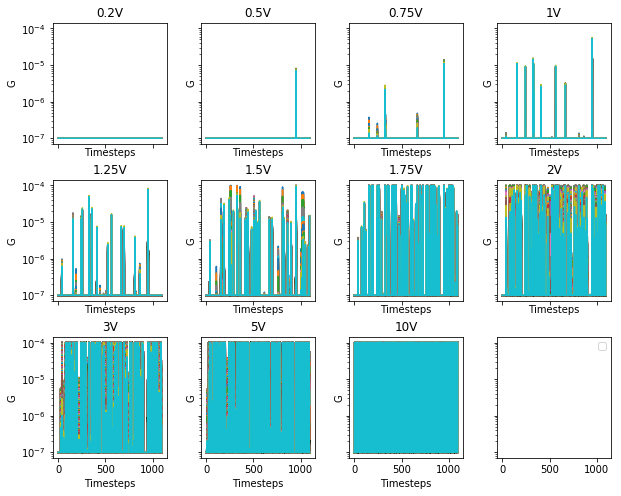

In [261]:
fig,axes=plt.subplots(3,4,figsize=(10,8),sharey=True,sharex=True)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
i=0
for ax in axes.flat:
    if i < 11:
        a=ax.plot(MCJuncCond[i][0].T)
        ax.set_yscale('log')
        ax.set_title(str(np.around(onAmp[i],2))+'V')
        ax.set_ylabel('G')
        ax.set_xlabel('Timesteps')
#         b=ax.plot(np.mean(NLTcond[i],axis=0).T,alpha=0.7)
    else:
        ax.legend([a],['MC'])
    i = i+1
    
# plt.savefig(saveFig+'Separated Network Conductance NLT+MC.pdf',format='pdf',dpi=300)

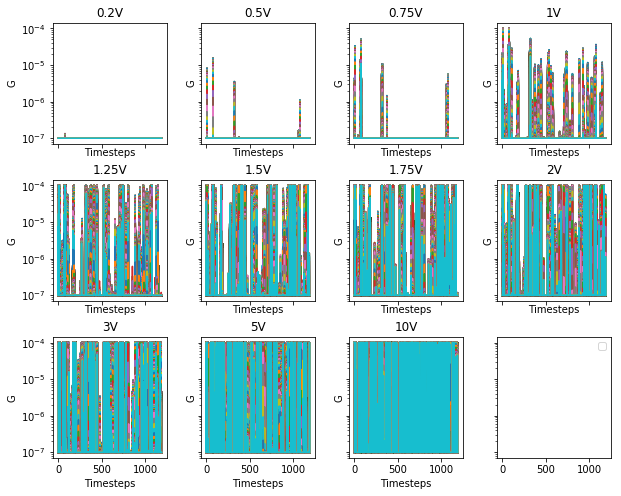

In [283]:
fig,axes=plt.subplots(3,4,figsize=(10,8),sharey=True,sharex=True)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
i=0
for ax in axes.flat:
    if i < 11:
        a=ax.plot(NLTJuncCond[i][0].T)
        ax.set_yscale('log')
        ax.set_title(str(np.around(onAmp[i],2))+'V')
        ax.set_ylabel('G')
        ax.set_xlabel('Timesteps')
#         b=ax.plot(np.mean(NLTcond[i],axis=0).T,alpha=0.7)
    else:
        ax.legend([a],['NLT'])
    i = i+1
    
# plt.savefig(saveFig+'Separated Network Conductance NLT+MC.pdf',format='pdf',dpi=300)

#### Multitasking

In [12]:
MultiTask_sims=[[[] for j in range(len(NWN))] for i in range(len(onAmp))]
for volt in tqdm(range(len(onAmp))):
    for i in range(len(NWN)):
        for j in range(numNWs): #for each modularity (integrated or segregated only)
            name2=dataLoc+'NLT+MC_Electrodes_seed10_wireVoltages'+'REWIRED_'+str(i+1)+'_'+str(j+1)+'_'+voltNames[volt]+'v.pkl'
            MultiTask_sims[volt][i].append(decompress_pickle(name2))

In [15]:
MultiTask_sims[0][0][-1].

{'JunctionConductance': array([[1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
        [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
        [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
        ...,
        [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
        [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07],
        [1.e-07, 1.e-07, 1.e-07, ..., 1.e-07, 1.e-07, 1.e-07]]),
 'JunctionVoltage': array([[ 3.92958245e-04, -3.09207080e-03,  4.27219277e-04, ...,
          2.81945966e-04,  4.76652373e-03, -9.42865885e-06],
        [-2.58310726e-04,  2.03038342e-03, -2.78650863e-04, ...,
         -1.81805010e-04, -3.12611156e-03,  1.14996640e-05],
        [ 2.43889078e-04, -1.92125045e-03,  2.67308472e-04, ...,
          1.78479245e-04,  2.96541036e-03, -6.13325577e-07],
        ...,
        [-2.31297690e-04,  1.82364033e-03, -2.55083632e-04, ...,
         -1.71816003e-04, -2.81748419e-03, -3.24794836e-06],
        [-8.31209935e-06,  6.82506033e-05, -1.18

In [262]:
def getWeightedGraph(sims,network,edgeList,numWires):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = sims['JunctionConductance']#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = sims['JunctionConductance']#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

In [263]:
nwnum=1

sources=[[] for i in range(len(onAmp))]
drains=[[] for i in range(len(onAmp))]
weightedSubGraph=[[] for i in range(len(onAmp))]
for volt in tqdm(range(len(MultiTask_sims))): #for each voltage
    for mod in range(numNWs): #for each module
        sim=MultiTask_sims[volt][nwnum][mod]
        network=np.array(nx.adjacency_matrix(graph[nwnum][mod]).todense()) #use sample network to show functional graph
        sources[volt].append(sim['Source'])
        drains[volt].append(sim['Drain'])
        OGgraph=graph[nwnum][mod].copy()
        pos=nx.kamada_kawai_layout(OGgraph)
        numWires=graph[nwnum][mod].number_of_nodes()
        sim['JunctionResistance']=1/sim['JunctionConductance']
        edgeList=np.array(list(graph[nwnum][mod].edges()))
#         subGraph=getOnGraph(sim,network,edgeList,numWires)
        weightedSubGraph[volt].append(getWeightedGraph(sim,network,edgeList,numWires))

In [2227]:
# maxWeightsNLT=[]
# minWeightsNLT=[]
# maxWeightsMC=[]
# minWeightsMC=[]
# for i in range(len(weightedSubGraph)): #for each voltage
#     weights=[]
#     weightsMin=[]
#     for j in range(len(weightedSubGraph[i])): #for each modularity
#         maxNW=np.argmax(NLT_same[j][i])
#         minNW=np.argmin(NLT_same[j][i])
#         G=weightedSubGraph[i][j]
#         edges=G.edges()
#         weights1=[G[u][v]['weight'] for u,v in edges]
#         weights.append([i * 1e6 for i in (weights1)])
#     maxWeightsNLT.append(np.max(np.hstack(weights)))
#     minWeightsNLT.append(np.min(np.hstack(weights)))
    
#     weightsMC=[]
#     weights1MC=[]
#     for j in range(len(weightedSubGraph[i])):
#         maxNW=np.argmax(MC_same[j][i])
#         minNW=np.argmin(MC_same[j][i])
#         G=weightedSubGraph[i][j]
#         edges=G.edges()
#         weights1MC.append([G[u][v]['weight'] for u,v in edges])
#         weightsMC.append([i * 1e6 for i in (weights1MC[j])])
#     if weightsMC[0]:
#         maxWeightsMC.append(np.max(np.array(weightsMC)))
#         minWeightsMC.append(np.min(np.array(weightsMC)))

In [264]:
weights1=[]
for i in tqdm(range(len(weightedSubGraph))): #for each voltage
    for j in range(len(weightedSubGraph[i])):#For each network
        G=weightedSubGraph[i][j]
        edges=G.edges()
        weights1.append([G[u][v]['weight'] for u,v in edges])

In [265]:
minWeights=np.min(np.hstack(weights1))
maxWeights=np.max(np.hstack(weights1))

In [394]:
maxWeights

0.00010010000000000001

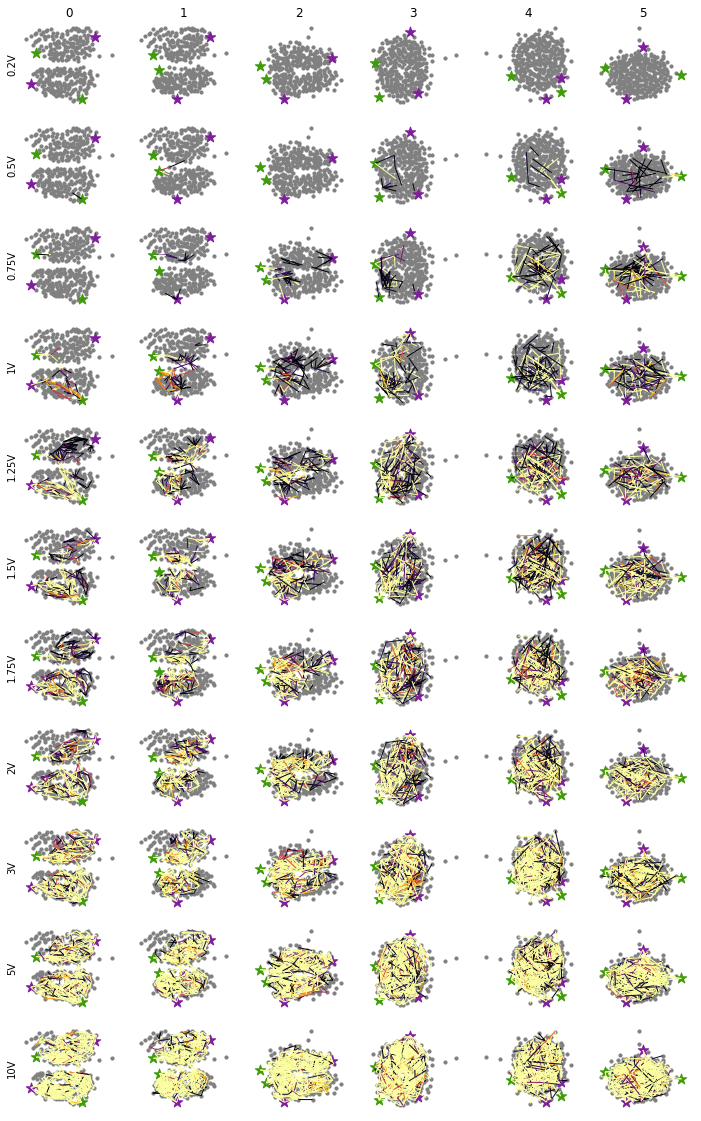

In [266]:
#### PLOT SUBGRAPHS + CURRENT OVERLAY
#Max NLT
fig, axes = plt.subplots(11,len(weightedSubGraph[0]),figsize=(12,20))
for i in tqdm(range(len(weightedSubGraph))): #for each voltage
    for j in range(len(weightedSubGraph[i])):#For each network

            #find top + bottom network
        ax=axes[i][j]
        G=weightedSubGraph[i][j]#current_new[i][j][maxNW]
        edge_weights=nx.get_edge_attributes(G,'weight')
        G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-6)) 
        edges=G.edges()
        weights=[G[u][v]['weight'] for u,v in edges]
        
        OGgraph=graph[nwnum][j]
        #draw OG graph
        pos=nx.kamada_kawai_layout(OGgraph)
        h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
        h.set_zorder(1)

        if j == 0:
            ax.set_ylabel(str(np.around(onAmp[i],2))+'V')
        if i == 0:
            ax.set_title(range(6)[j])
        h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.inferno,edge_vmin=minWeights,edge_vmax=maxWeights)
    
        if h2:
            h2.set_norm(clrs.SymLogNorm(10))
            h2.set_zorder(3)
#             if j == 10 and i == 6:
#                 plt.colorbar(h2)
        nx.draw_networkx_nodes(G,pos=pos,nodelist=sources[i][j],node_color='#3f9b0b',node_size=120,node_shape ='*',ax=ax)
        nx.draw_networkx_nodes(G,pos=pos,nodelist=drains[i][j],node_color='#7e1e9c',node_size=120,node_shape ='*',ax=ax)
        ax.set_frame_on(False)
           
#         ax.annotate('NLT = '+"{0:.2f}".format(NLT_same[j][i]),xy=(0.5,1),xycoords='axes fraction')
#         ax.annotate('MC = '+"{0:.2f}".format(MC_same[j][i]),xy=(0.5,0.9),xycoords='axes fraction')
        
        ax.set_yticks([])
        ax.set_xticks([])

    plt.savefig(saveFig+'VSweep 300NWN SameAvgDeg 2Modules ElecInEachModule - Conductance Graphs MultiTasking'+str(nwnum)+'.pdf',format='pdf',dpi=300)